<a href="https://colab.research.google.com/github/dmourlot89/MELI_challenge/blob/main/MELI_DSChallenge_Q4(II).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 4. Series de tiempo

### **Descripción**

Pronosticar las ventas de un producto o de una categoría es un desafío recurrente para cualquier ecommerce.

En este caso, el desafío va a ser pronosticar la cantidad de unidades diarias que van a vender 3 categorías distintas de MELI.

El dataset “series.csv” tiene las ventas en unidades diarias de 3 categorías que
poseen un id único y su fecha de venta.

### **Entregable**
El objetivo de este desafío es construir un modelo de forecast que permita estimar las ventas de 3 semanas a nivel diario utilizando la historia de ventas de la categoría. Es decir, predecir las ventas de los siguientes 21 días. Las métricas y la medición de la performance del forecast son un punto clave de este desafío.

**TIP: Dividir el dataset en entrenamiento, testing y validación correctamente es muy importante en problemas de forecasting!**


In [1]:
# Import neccesary libraries and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [212]:
# load dataset from github repository
url = 'https://raw.githubusercontent.com/dmourlot89/MELI_challenge/main/series.csv'
dtype = {
    'CATEGORY': 'category'
}
series_df = pd.read_csv(url,parse_dates = ["DATE"],
                        dtype = dtype,
                        infer_datetime_format = True)

# Set Date column as index
#series_df = (series_df.set_index(['DATE']).sort_index(ascending = True))

In [19]:
print(series_df.shape)
series_df.head()

(2686, 3)


,CATEGORY,DATE,UNITS_SOLD
0,CATEG-1,2021-08-17,59
1,CATEG-1,2020-09-19,40
2,CATEG-2,2021-10-26,23
3,CATEG-1,2021-04-27,60
4,CATEG-2,2021-05-05,61


In [213]:
min_date = series_df.DATE.min()
max_date = series_df.DATE.max()

print(min_date)
print(max_date)

2018-09-24 00:00:00
2021-11-12 00:00:00



Comprobar si hay fechas faltantes en nuestro dataset



In [22]:
num_days = ((max_date + pd.Timedelta(days = 1)) - min_date)/pd.Timedelta(days = 1) 
actual = len(series_df.DATE.unique())

print(f"Days from {min_date} to {min_date}: {num_days}")
print(f"Days actually present in our dataset: {actual}")

Days from 2018-09-24 00:00:00 to 2018-09-24 00:00:00: 1146.0
Days actually present in our dataset: 921


Hay 225 dias del periodo para los cuales no tenemos registros en ninguna de las categorias.

Inspeccionemos ahora las categorias...

In [24]:
series_df[['CATEGORY', 'DATE']].groupby('CATEGORY').count()

,DATE
CATEGORY,
CATEG-1,887
CATEG-2,879
CATEG-3,920


Faltan registros de al menos una categoria en varias fechas de las presentes en nuestro dataset.

## Feature Engineering

Primero creemos nuestro working data frame y setiemos la columna DATE como indice. 

In [214]:
working_df = series_df.copy()
working_df = working_df.set_index('DATE').sort_index(ascending = True)
working_df.head()

,CATEGORY,UNITS_SOLD
DATE,,
2018-09-24,CATEG-3,0
2018-09-25,CATEG-3,0
2018-09-27,CATEG-3,0
2018-09-28,CATEG-3,2
2018-09-29,CATEG-3,1


### Time-dependent variables

Crear una feature 'time dummy' que nos permitira comenzar a explorar la dependencia temporal presente en  nuestra serie.

In [215]:
index = pd.date_range(start= min_date, end=max_date)
data = range(len(index))
aux = pd.DataFrame(data = data, index = index, columns=['Time'])

# Create Time column with daily frequency
working_df['Time'] = aux[aux.index.isin(working_df.index)].Time
working_df['Time']

DATE
2018-09-24       0
2018-09-25       1
2018-09-27       3
2018-09-28       4
2018-09-29       5
              ... 
2021-11-11    1144
2021-11-11    1144
2021-11-12    1145
2021-11-12    1145
2021-11-12    1145
Name: Time, Length: 2686, dtype: int64

Graficar nuestra serie temporal

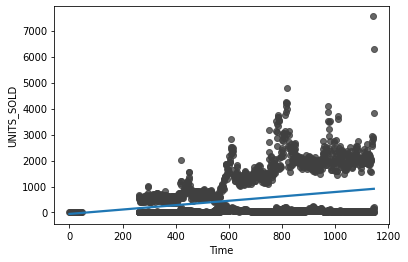

In [37]:
sns.regplot(x='Time', y='UNITS_SOLD', data=working_df, ci=None, scatter_kws=dict(color='0.25'))

En la grafica anterior podemos apreciar que hay cierta coincidencia (o zolapamiento) en las tendencias de dos de las categorias, pero la otra parece diferir --tanto en volumenes de ventas como en tendencias.

Exploremos un poco mas...

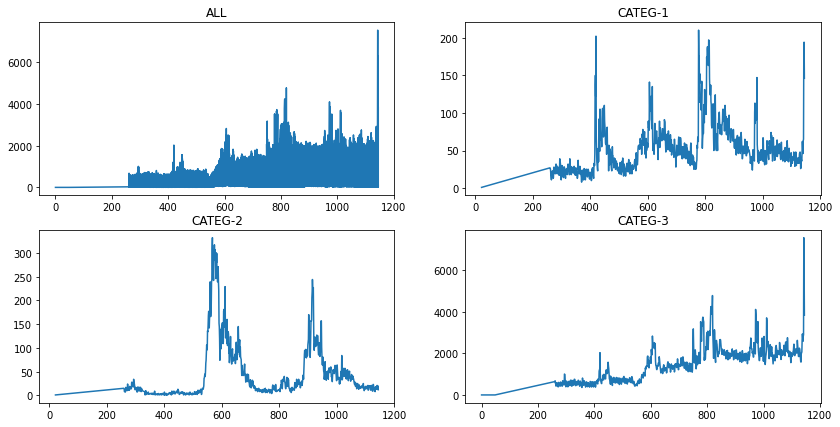

In [216]:
fig, axs = plt.subplots(2,2, figsize=(14,7))

# Complete TS (All categories)
axs[0,0].plot(working_df.Time, working_df.UNITS_SOLD)
axs[0, 0].set_title("ALL")

# Category 1 
axs[0,1].plot(working_df[working_df.CATEGORY == 'CATEG-1'].Time, working_df[working_df.CATEGORY == 'CATEG-1'].UNITS_SOLD)
axs[0, 1].set_title("CATEG-1")

# Category 2 
axs[1,0].plot(working_df[working_df.CATEGORY == 'CATEG-2'].Time, working_df[working_df.CATEGORY == 'CATEG-2'].UNITS_SOLD)
axs[1, 0].set_title("CATEG-2")

# Category 3
axs[1,1].plot(working_df[working_df.CATEGORY == 'CATEG-3'].Time, working_df[working_df.CATEGORY == 'CATEG-3'].UNITS_SOLD)
axs[1, 1].set_title("CATEG-3")

plt.show()

In [42]:
for d in range(0,1201,200):
  print(d, min_date + pd.Timedelta(days = d))

0 2018-09-24 00:00:00
200 2019-04-12 00:00:00
400 2019-10-29 00:00:00
600 2020-05-16 00:00:00
800 2020-12-02 00:00:00
1000 2021-06-20 00:00:00
1200 2022-01-06 00:00:00


Como se preveia, las categorias 1 y 3 muestran muchas similitudes: 
- tendencias al alza respecto a septiembre de 2019
- picos de ventas en los periodos de mayo-junio y noviembre-diciembre
(Sin embargo difieren en la cantidad de productos vendidos, siendo la categoria 3 muy superior en este apartado.)

La categoria 2, por su parte, muestra una tendencia mas estable a lo largo de todo el periodo. Tambien muestra picos elevados en las ventas alrededor de mayo de 2020 y de 2021 (asi como otro mucho mas pequenho cerca de diciembre de 2020)

INSIGHT: Los picos en mayo-junio y noviembre-diciembre una posible informacion de seasonality, la cual podria capturarse con variables para representar los meses, por ejemplo. 
Asi mismo, debemos explorar si el uso de una variable tipo hot encoding para CATEGORY puede capturar la informacion de las diferencias entre categorias o si, en cambio, es mejor entrenar un modelo para cada categoria.

Descomponer DATE en distintas features con potencia informacion de seasonality

In [217]:
working_df['YEAR'] = working_df.index.year.astype('category')
working_df['MONTH'] = working_df.index.month.astype('category')
working_df['DAY_IN_WEEK'] = working_df.index.weekday

# see new features
working_df

,CATEGORY,UNITS_SOLD,Time,YEAR,MONTH,DAY_IN_WEEK
DATE,,,,,,
2018-09-24,CATEG-3,0,0,2018,9,0
2018-09-25,CATEG-3,0,1,2018,9,1
2018-09-27,CATEG-3,0,3,2018,9,3
2018-09-28,CATEG-3,2,4,2018,9,4
2018-09-29,CATEG-3,1,5,2018,9,5
...,...,...,...,...,...,...
2021-11-11,CATEG-3,6294,1144,2021,11,3
2021-11-11,CATEG-1,194,1144,2021,11,3
2021-11-12,CATEG-1,146,1145,2021,11,4


Veamos las ventas por anho y mes

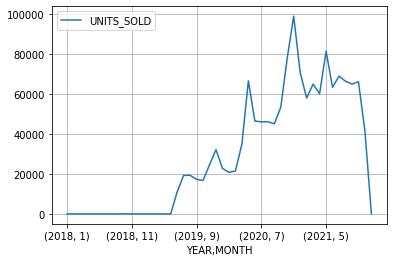

In [218]:
monthly_sales = working_df[['YEAR','MONTH','UNITS_SOLD']].groupby(['YEAR','MONTH']).sum()
monthly_sales.plot(grid = True)

Los picos de ventas alrededor de los meses de mayo y diciembre vuelven a hacerse evidentes en esta grafica.

Ahora echemos un vistazo a las ventas por dias de la semana

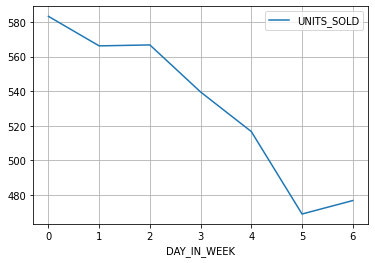

In [219]:
weekly_sales = working_df[['DAY_IN_WEEK','UNITS_SOLD']].groupby(['DAY_IN_WEEK']).mean()
weekly_sales.plot(grid = True)

Parece haber una tendencia, con las ventas decayendo hacia el final de la semana

In [220]:
def minMaxNormalize(df):
  '''
  Perform MinMax normalization on numerical columns
  '''
  return (df-df.min())/(df.max()-df.min())

In [221]:
def trainTestModel(model, X_train, X_test, y_train, y_test):
  # Fit model model to train data
  model.fit(X_train,y_train)

  # Train error 
  train_pred = model.predict(X_train)   # predictions for train dataset
  # use RMSE (real scale results) and normalize it to get 0-1 score
  error_train = np.sqrt(mean_squared_error(y_train,train_pred))
  
  # Test error
  test_pred = model.predict(X_test)
  error_test = np.sqrt(mean_squared_error(y_test,test_pred))

  return error_train, error_test

In [222]:
def plotTrainVSTest(x_data, train_errors, test_errors):
  plt.plot(x_data,train_errors)
  plt.plot(x_data,test_errors)
  plt.title("Train vs Test Error")
  plt.xlabel("Degree")
  plt.ylabel("RMSE")

  plt.show()

Utilizar solamente nuestra variable time-step (time dummy 'Time') para entrenar nuestro modelo de Regresion Lineal

In [223]:
X = working_df.iloc[:,2].to_frame()
print(type(X))
# Scale Time column (values too big compared to the other feature's values)
#X_norm = minMaxNormalize(X.to_frame())
y = working_df.loc[:,'UNITS_SOLD']

# Split data into train and test dataset (75-25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create Linear Regression model
lr_model = LinearRegression()

error_train, error_test = trainTestModel(lr_model, X_train,X_test,y_train,y_test)
# Normalize RMSE to get a 0-1 score
error_train = error_train/(y_train.max() - y_train.min())
error_test = error_test/(y_test.max() - y_test.min())

# Print scores
print(f"Error Train: {error_train:.2f}")
print(f"Error Test: {error_test:.2f}")

<class 'pandas.core.frame.DataFrame'>
Error Train: 0.11
Error Test: 0.17


Ambos errores son muy altos, lo que indica un problema de Bias (i.e. nuestro modelo de una variable es demasiado simple para captar la distribucion de la ST).  En estos casos, una buena estrategia es agregar features (complejidad) a nuestro modelo.

Probemos primero utilizando transformaciones polynomiales de nuestro time dummy.

[0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11]
[0.181, 0.251, 0.913, 11.34, 141.99, 903.846, 4039.598, 14148.053, 35198.57]


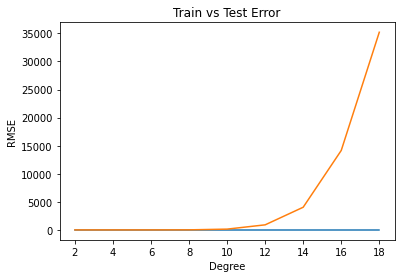

In [225]:
from sklearn.preprocessing import PolynomialFeatures
# get Time column
X = series_df.iloc[:,2].to_frame()
train_errors = []
test_errors = []
degrees = range(2,20,2)
for d in degrees:
  X_poly = PolynomialFeatures(d).fit_transform(X)
  # Scale Time column (exponentiated values would be
  # to big compared to Time and other feature's values)
  X_norm = minMaxNormalize(X_poly)
  
  # Split data into train and test dataset (75-25)
  X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=42)

  # Create Linear Regression model
  lr_model = LinearRegression()

  # Train and test LR model
  error_train, error_test = trainTestModel(lr_model, X_train,X_test,y_train,y_test)
  # Normalize RMSE to get a 0-1 score
  error_train = error_train/(y_train.max() - y_train.min())
  error_test = error_test/(y_test.max() - y_test.min())
  train_errors.append(round(error_train,3))
  test_errors.append(round(error_test,3))

print(train_errors)
print(test_errors)

plotTrainVSTest(degrees, train_errors, test_errors)

In [226]:
(y_test.max() - y_test.min())

4773

Agregar transformaciones polynomiales de la variable Time, no solo falla al intentar aliviar el problema de Bias (underfitting), sino que ademas agrega un problema de alta varianza (nuestro modelo es cada vez menos capaz de generalizar bien a ejemplos no vistos). Por tanto, desechemos esta variante

Intentemos ahora agregar la informacion que portan la variable CATEGORY (diferencia en las ventas de una y otra), asi como MONTH y WEEK (posible seasonality), usando one-hot encoding.

In [227]:
#working_df = pd.get_dummies(series_df, columns = ['CATEGORY','YEAR','MONTH','DAY_IN_WEEK'])
working_df = pd.get_dummies(working_df, columns = ['CATEGORY','MONTH', 'DAY_IN_WEEK'])
working_df.columns

Index(['UNITS_SOLD', 'Time', 'YEAR', 'CATEGORY_CATEG-1', 'CATEGORY_CATEG-2',
       'CATEGORY_CATEG-3', 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4',
       'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10',
       'MONTH_11', 'MONTH_12', 'DAY_IN_WEEK_0', 'DAY_IN_WEEK_1',
       'DAY_IN_WEEK_2', 'DAY_IN_WEEK_3', 'DAY_IN_WEEK_4', 'DAY_IN_WEEK_5',
       'DAY_IN_WEEK_6'],
      dtype='object')

Entrenar nuestro modelo de RL con time dummy + las nuevas features creadas

In [233]:
cat_month_days = working_df[['Time','CATEGORY_CATEG-1','CATEGORY_CATEG-2', 'CATEGORY_CATEG-3',
               'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
               'MONTH_7', 'MONTH_8', 'MONTH_9','MONTH_10', 'MONTH_11', 'MONTH_12',
               'DAY_IN_WEEK_0', 'DAY_IN_WEEK_1','DAY_IN_WEEK_2','DAY_IN_WEEK_3',
               'DAY_IN_WEEK_4', 'DAY_IN_WEEK_5', 'DAY_IN_WEEK_6']]

cat_month = cat_month_days.iloc[:,:-7]

Index(['Time', 'CATEGORY_CATEG-1', 'CATEGORY_CATEG-2', 'CATEGORY_CATEG-3',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
       'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'],
      dtype='object')

In [235]:
X = cat_month_days
# Scale Time column (values too big compared to the other feature's values)
X_norm = minMaxNormalize(X)
y = working_df.loc[:,'UNITS_SOLD'].to_frame()

# Split data into train and test dataset (75-25)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=42)
error_train, error_test = trainTestModel(lr_model, X_train,X_test,y_train,y_test)
# Normalize RMSE to get a 0-1 score
error_train = error_train/(y_train.max() - y_train.min())
error_test = error_test/(y_test.max() - y_test.min())
print(f"Error Train: {error_train}")
print(f"Error Test: {error_test}")

Error Train: UNITS_SOLD    0.056003
dtype: float64
Error Test: UNITS_SOLD    0.091366
dtype: float64


El RMES se reduce en aproximadamente un 50%, demostrando que las nuevas features anhadidas contienen informacion relevante sobre el comportamiento de la ST.

(OJO: sin Time el error se reduce considerablemente igual, pero menos que cuando se incluye esta feature tambien. O sea, cuenta.)

### Lag Features

Existen dos tipos de features que son unicas de las ST, los time steps (arriba)
 y las llamadas 'lag features'.

 Estas ultimas nos permiten modelar la dependencia serial (serial dependence), esto es cuando el valor de una observacion puede predecirse por los valores de las observaciones anteriores. De modo que buscamos crear lag features que esten fuertemente correlacionadas con nuestro target (UNITS_SOLD). 


Creeemos algunas...

In [242]:
# helper functions
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

def make_lags(ts, lags):
  return pd.concat(
      {
          f'y_lag_{i}': ts.shift(i)
          for i in range(1, lags + 1)
      },
      axis=1)


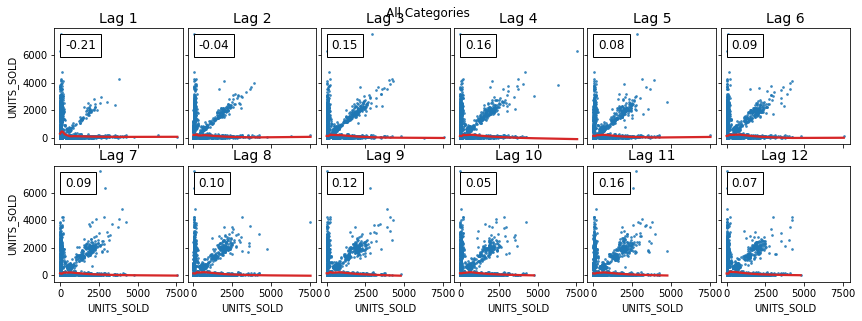

In [237]:
fig = plot_lags(working_df.UNITS_SOLD, lags=12, nrows=2)
fig.suptitle('All Categories\n\n\n')
fig.show()

Aunque el metodo de correlacion lineal no es capaz de hallarla, al observar la grafica es evidente que existe una fuerte correlacion entre las observaciones pasadas y nuestro target, solo que dentro de una misma categoria!

Veamos para las categorias por separado...

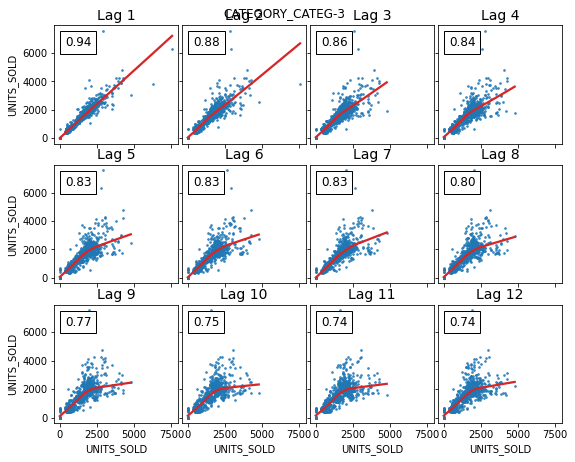

In [238]:
#category = 'CATEGORY_CATEG-1'
#category = 'CATEGORY_CATEG-2'
category = 'CATEGORY_CATEG-3'

fig = plot_lags(working_df[working_df[category] == 1].UNITS_SOLD, lags=12, nrows=3)
fig.suptitle(category + '\n\n\n')
fig.show()

Cuando analizamos por categorias la correlacion entre los lags y la variable target es fuerte (0.6+) hasta la lag 8, en la categoria 1, y en las otras dos  hasta la lag 22 (por lo menos)!!

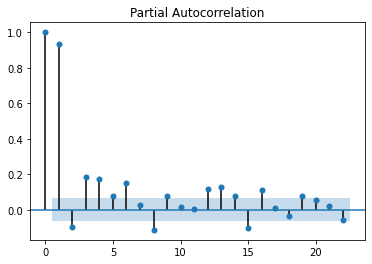

In [239]:
from statsmodels.graphics.tsaplots import plot_pacf

_ = plot_pacf(working_df[working_df['CATEGORY_CATEG-3'] == 1].UNITS_SOLD, lags=22)

Ahora, creemos unas lags y veamos como ayudan a nuestro modelo...

In [243]:
X = cat_month_days

lags = make_lags(working_df.UNITS_SOLD, lags=30)
lags = lags.fillna(0.0)

X = pd.concat([X,lags], axis = 1)
# Scale Time and lags column (values too big compared to the other feature's values)
X_norm = minMaxNormalize(X)
y = working_df.loc[:,'UNITS_SOLD'].to_frame()

error_train, error_test = trainTestModel(lr_model, X_train,X_test,y_train,y_test)
# Normalize RMSE to obtain a 0-1 score
error_train = error_train/(y_train.max() - y_train.min())
error_test = error_test/(y_test.max() - y_test.min())
print(f"Train error: {error_train}")
print(f"Test error: {error_test}")


Train error: UNITS_SOLD    0.056003
dtype: float64
Test error: UNITS_SOLD    0.091366
dtype: float64


Hasta un lag 30 (dias antes de la prediccion) se obtienen mejoras del error tanto en el set de entrenamiento, como en el prueba -- a partir de ese lag se empiezan a notar signos de overfitting (disminuye el training error pero aumenta el Test error).


Probemos a crear modelos especificos para cada categoria y veamos que tal les va.

In [244]:
X = cat_month_days
lags = make_lags(working_df.UNITS_SOLD, lags=22)
lags = lags.fillna(0.0)

X = pd.concat([X,lags], axis = 1)
# Select data points for a single category
category = 'CATEGORY_CATEG-2'
# drop all category-related columns since they are no loger useful
X = X[X[category] == 1].drop(columns = ['CATEGORY_CATEG-1','CATEGORY_CATEG-2', 'CATEGORY_CATEG-3'])

# Scale Time and lag columns (values too big compared to the other feature's values)
X_norm = minMaxNormalize(X)
y = working_df[working_df[category] == 1].UNITS_SOLD.to_frame()

# Split data into train and test dataset (75-25)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=42)
error_train, error_test = trainTestModel(lr_model, X_train,X_test,y_train,y_test)
# Normalize RMSE to obtain a 0-1 score
error_train = error_train/(y_train.max() - y_train.min())
error_test = error_test/(y_test.max() - y_test.min())
print(f"Train error: {error_train}")
print(f"Test error: {error_test}")

Train error: UNITS_SOLD    0.105965
dtype: float64
Test error: UNITS_SOLD    0.116767
dtype: float64


**Conclusion modelado con Regresion Lineal:**

Los resultados obtenidos cuando analizamos separando por categoria, no son pesimos (exceptuando quizas para la categoria 2), pero tampoco son buenos del todo. 

No parece haber problemas de overfitting, pues el error en el dataset de prueba es bien cercano al de entrenamiento.

**Red Neuronal (MLPRegressor)**

Probemos un algoritmo mas complejo como una red neuronal, a ver si podemos bajar nuestro RMSE...

Let's try first with all features and all data points together

In [251]:
from sklearn.neural_network import MLPRegressor
# TS can be typically decomposed into four components:
# trend, season, and residual. So let's try 3 hidden layers,
# see if our NN can learn to predict each one of them 
mlp_regr = MLPRegressor((100,100,100), alpha = 0.01, random_state=1, max_iter=500)

X = cat_month_days

lags = make_lags(working_df.UNITS_SOLD, lags=22)
lags = lags.fillna(0.0)

X = pd.concat([X,lags], axis = 1)
# Scale Time and lag columns (values too big compared to the other feature's values)
X_norm = minMaxNormalize(X)
y = working_df.loc[:,'UNITS_SOLD']

# Split 1,500data into train and test dataset (75-25)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=42)

# Train and test NN model
error_train, error_test = trainTestModel(mlp_regr, X_train,X_test,y_train,y_test)
# Normalize RMSE to obtain a 0-1 score
error_train = error_train/(y_train.max() - y_train.min())
error_test = error_test/(y_test.max() - y_test.min())
print(f"Train error: {error_train:.2f}")
print(f"Test error: {error_test:.2f}")
# See R^2 score (best result is 1.0)
print(f"R^2 score on test set: {mlp_regr.score(X_test, y_test):.2f}")


Train error: 0.02
Test error: 0.04
R^2 score on test set: 0.95


Vamos a probar un modelo de RN para cada categoria, a ver que tal es el desempenho

In [250]:
# TS can be typically decomposed into four components:
# trend, season, and residual. So let's try 3 hidden layers,
# see if our NN can learn to predict each one of them 
mlp_regr = MLPRegressor((100,100,100), alpha = 0.01, random_state=1, max_iter=5000)

X = cat_month_days

lags = make_lags(working_df.UNITS_SOLD, lags=22)
lags = lags.fillna(0.0)

X = pd.concat([X,lags], axis = 1)
# Select data points for a single category
category = 'CATEGORY_CATEG-2'
# drop all category-related columns since they are no loger useful
X = X[X[category] == 1].drop(columns = ['CATEGORY_CATEG-1','CATEGORY_CATEG-2', 'CATEGORY_CATEG-3'])

# Scale Time and lag columns (values too big compared to the other feature's values)
X_norm = minMaxNormalize(X)
y = working_df[working_df[category] == 1].UNITS_SOLD.to_frame()

# Train and test NN model
error_train, error_test = trainTestModel(mlp_regr, X_train,X_test,y_train,y_test)
# Normalize RMSE to obtain a 0-1 score
error_train = error_train/(y_train.max() - y_train.min())
error_test = error_test/(y_test.max() - y_test.min())
print(f"Train error: {error_train:.2f}")
print(f"Test error: {error_test:.2f}")
# See R^2 score (best result is 1.0)
print(f"R^2 score on test set: {mlp_regr.score(X_test, y_test):.2f}")

Train error: 0.02
Test error: 0.04
R^2 score on test set: 0.95
